In [1]:
import json
import copy
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

random.seed(42)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [2]:
map = mpimg.imread("map.png")  # US States & Capitals map

with open('capitals.json', 'r') as capitals_file:
    capitals = json.load(capitals_file)
    
capitals_list = list(capitals.items())
capitals_list = [(c[0], tuple(c[1])) for c in capitals_list]
def show_path(path, starting_city, w=12, h=8):
    x, y = list(zip(*path))
    _, (x0, y0) = starting_city
    plt.imshow(map)
    plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point
    plt.plot(x + x[:1], y + y[:1])  # include the starting point at the end of path
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])

In [3]:
import itertools

def simulated_annealing(problem, schedule, method='swap'):
    current = problem
    minm_temp = 1e-10
    
    for time in itertools.count():
        temperature = schedule(time)
        if temperature <= 1e-10:
            return current

        successors = current.successors(method)
        candidate_for_current = successors[random.randint(0, len(successors) - 1)]
        
        delta_e = candidate_for_current.get_value() - current.get_value()

        if delta_e > 0:
            current = candidate_for_current
            
        elif random.random() < np.exp(delta_e / temperature):
            current = candidate_for_current

In [4]:
from itertools import permutations # for calculating neighbors
from numpy import roll

class TravelingSalesmanProblem:

    def __init__(self, cities):
        self.path = copy.deepcopy(cities)
    
    def copy(self):
        new_tsp = TravelingSalesmanProblem(self.path)
        return new_tsp
    
    @property
    def names(self):
        names, _ = zip(*self.path)
        return names
    
    @property
    def coords(self):
        _, coords = zip(*self.path)
        return coords
    
    def _get_cyclic_permut(self, path, itself=False):
        reverse = list(reversed(path))
        start = 0 if itself else 1
        same_cycles = {tuple(path[i:] + path[:i]) for i in range(start, len(path))} | {
            tuple(reverse[i:] + reverse[:i]) for i in range(start, len(reverse))}
        return same_cycles
    
    def successors(self, method='swap'):
        successors = []
        
        if method == 'swap':
            N = len(self.path)
            for i in range(N):
                s = self.copy()
                swap_with = (i + 1) % N
                s.path[i], s.path[swap_with] = s.path[swap_with], s.path[i]
                successors.append(s)          
        
        successor_paths = list(set(permutations(self.path)) - self._get_cyclic_permut(self.path, itself=True))
        
        if method == 'all':
            
                for p in successor_paths:
                    s = self.copy()
                    s.path = tuple(p)
                    successors.append(s)
            
        
        if method == 'circular':
 
                circular_permut = []
                for path in successor_paths:
                    circular_permut.append(path)
                    same = self._get_cyclic_permut(path)
                    for s in same:
                        if s in successor_paths:
                             successor_paths.remove(s)
                                
                         
                for p in circular_permut:
                    s = self.copy()
                    s.path = tuple(p)
                    successors.append(s)

        return successors

    def get_value(self):
        value = 0
        path = list(self.path) + [self.path[0]]
        pairs = zip(path, path[1:])
        for t1, t2 in pairs:
            value += np.sqrt((t1[1][0] - t2[1][0])**2 + (t1[1][1] - t2[1][1])**2)
            
        return -value

In [5]:
alpha = 0.95
temperature=1e4

def schedule(time):
    return alpha ** time * temperature

Initial path value: 1951.05
[('Atlanta', (585.6, 376.8)), ('Des Moines', (447.6, 246.0)), ('Salem', (80.0, 139.2)), ('Tallahassee', (594.8, 434.8)), ('Nashville', (546.4, 336.8)), ('Austin', (389.2, 448.4)), ('Columbus', (590.8, 263.2)), ('Richmond', (673.2, 293.6))]


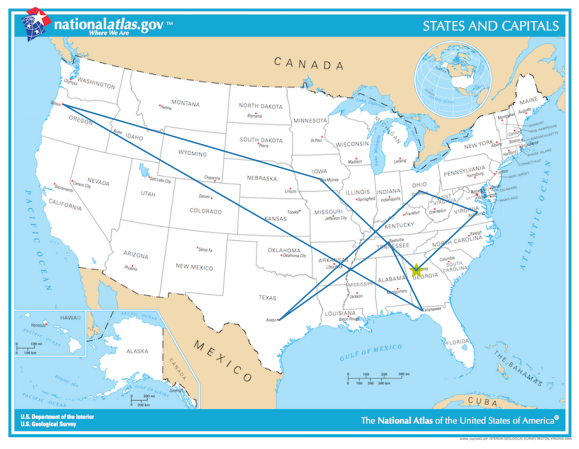

In [6]:
# Create the problem instance and plot the initial state
num_cities = 8
random.Random(42).shuffle(capitals_list)
capitals_tsp = TravelingSalesmanProblem(capitals_list[:num_cities])
starting_city = capitals_list[0]
print("Initial path value: {:.2f}".format(-capitals_tsp.get_value()))
print(capitals_list[:num_cities])
show_path(capitals_tsp.coords, starting_city)

# Finding better Parameters

Final path length: 1513.63
[('Richmond', (673.2, 293.6)), ('Atlanta', (585.6, 376.8)), ('Tallahassee', (594.8, 434.8)), ('Austin', (389.2, 448.4)), ('Salem', (80.0, 139.2)), ('Des Moines', (447.6, 246.0)), ('Nashville', (546.4, 336.8)), ('Columbus', (590.8, 263.2))]
CPU times: user 34 s, sys: 342 ms, total: 34.3 s
Wall time: 44.7 s


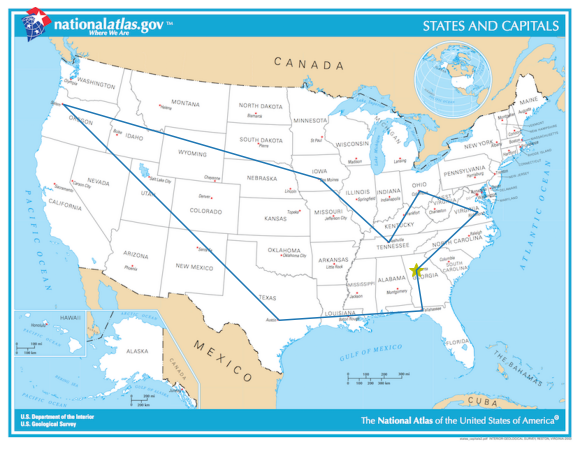

In [7]:
%%time
alpha = 0.95
temperature=1e6

result = simulated_annealing(capitals_tsp, schedule, method='swap')

print("Final path length: {:.2f}".format(-result.get_value()))
print(result.path)
show_path(result.coords, starting_city)